## Simple tutorial on exploratory model building on a subset of the Airbnb dataset.

In this introductory notebook, we will take a closer look at the Airbnb data. This is by no means a "perfect" analysis, but serves only as an introduction to how one might approach a problem such as the one at hand. So the analyses performed are only meant as a kind of inspiration for your own models.

The variable selection is arbitrary and not every potentially valuable variable is used. We will for instance only use some of the structural variables and the images, but no text data.

In this simple tutorial you will learn:

* How to read in and read out the images for modeling.
* How to deal with missing data
    * Simple imputation transformations to fill in missing values, such as using the median
* How to preprocess structural variables
* Creating base models for the structural variables for data exploration.
    * Simple linear regression
    * Decision Tree Regression
    * Random Forest Regression
* How to create a Multi Layer Perceptron (MLP).
    * How to use sklearn and tensorflow.keras
* How to build a basic Convolutional Neural Network (CNN).
* Predicting the RMSE using your CNN architecture.
* How to build a CNN with multiple inputs and mixed data.


The goal of your analyses is to build a model that predicts Airbnb rental prices fairly accurately while providing good interpretability.


## Index
#### 1. Load the data and scrape the images

#### 2. Data Exploration

#### 3. Model building using only the structural variables

#### 4. Model building using the images


# 1. Load the data

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns

<IPython.core.display.Javascript object>

I chose only to use the first 1000 observations of the available data to have a faster computation time.
In this tutorial we will not use the 4 datasets loaded below but will solely focus on the listings.csv.gz file.

In [3]:
listings = pd.read_csv("listings.csv")[0:500]
reviews = pd.read_csv("reviews.csv")[0:500]
reviews_meta = pd.read_csv("reviews.csv.gz")[0:500]
calendar = pd.read_csv("calendar.csv.gz")[0:500]

<IPython.core.display.Javascript object>

Load the main data file

In [4]:
train_df = pd.read_csv("listings.csv.gz")[0:1000]

<IPython.core.display.Javascript object>

In [5]:
# drop all rows where no pictures are available
train_df = train_df.dropna(subset=["picture_url", "host_picture_url"])
train_df = train_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

Unfortunately, the variable we are interested in, the price, is given in a string format in the form of  "10.00$".

For easier computation we transform these strings into floats

In [6]:
# transform price
train_df["price"] = (
    train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

C:\Users\anton\AppData\Local\Temp/ipykernel_6748/1798223733.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)


<IPython.core.display.Javascript object>

Additionaly let's compute the log price, as predicting the log price gives us some advantages we will see later in the notebook

In [7]:
train_df["log_price"] = np.log(train_df["price"])

<IPython.core.display.Javascript object>

As you can see below, we have an enormous amount of available data (75 columns + additional files). However, some of these variables contain essentially the same or extremely correlated information. For example, I would guess that the sentiment of a written review is highly correlated with the given *star* rating.

In [8]:
train_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

<IPython.core.display.Javascript object>

Let's have a quick look at the data. We have 75 columns with a lot of variables that probably do not bare any explanation in them at all.

In [9]:
train_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,log_price
0,97945,https://www.airbnb.com/rooms/97945,20210928184710,2021-09-28,Deluxw-Apartm. with roof terrace,"<b>The space</b><br />We offer a modern, quiet...",We are living in a outskirt of Munich its call...,https://a0.muscache.com/pictures/2459996/10b4c...,517685,https://www.airbnb.com/users/show/517685,...,4.78,4.73,NaN,f,2,2,0,0,1.13,4.574711
1,114695,https://www.airbnb.com/rooms/114695,20210928184710,2021-09-28,Apartment Munich/East with sundeck,<b>The space</b><br />It´s a quiet and sunny a...,NaN,https://a0.muscache.com/pictures/21571874/960e...,581737,https://www.airbnb.com/users/show/581737,...,4.55,4.60,NaN,f,2,2,0,0,0.48,4.553877
2,127383,https://www.airbnb.com/rooms/127383,20210928184710,2021-09-28,City apartment next to Pinakothek,<b>The space</b><br />My cosy apartment is loc...,NaN,https://a0.muscache.com/pictures/79238c11-bc61...,630556,https://www.airbnb.com/users/show/630556,...,4.91,4.82,NaN,f,1,1,0,0,1.06,4.595120
3,159634,https://www.airbnb.com/rooms/159634,20210928184710,2021-09-29,"Fancy, bright central roof top flat and homeof...",In this idyllic stylish flat you live very qui...,"Very quiet, green, squirrels and beergardens a...",https://a0.muscache.com/pictures/4203314/ed102...,765694,https://www.airbnb.com/users/show/765694,...,4.50,4.34,NaN,t,1,1,0,0,0.36,3.951244
4,170154,https://www.airbnb.com/rooms/170154,20210928184710,2021-09-29,"Own floor & bath, parking & breakfast","Enjoy a quiet neighbourhood, easy access to th...",NaN,https://a0.muscache.com/pictures/31636890/593e...,108297,https://www.airbnb.com/users/show/108297,...,4.76,4.90,NaN,f,1,0,1,0,4.51,4.521789


<IPython.core.display.Javascript object>

### "Scrape" the images

First, we try to scrape the available images: 

This loop, as terrible as it is written, loops through the given flat-picture and host-picture URL's and appends the scraped pictures to two lists. We resize the images to a size of 224 by 224 pixels and normalize them by dividing through 255 (the maximum pixel value). All images that cannot be scraped or are not with rgb are dropped from the dataframe. This is obviously optional and can be handled differently by your approach.

The used picture size of 224x224 is also done randomly. Have in mind, however, that larger pixel values (while maybe giving you better prediction results) will give you longer computation times. However, using e.g. 8x8 images as is sometimes done with the MNIST data sets will give you unrecognizable flat images.

Depending on your number of observations this can take a while. Therefore it is sensible for you (if you haven't already) to start your analysis by scrapping all images and (obviously) saving them.

In [10]:
pictures_flat = []
pictures_host = []
for i in tqdm(range(len(train_df))):

    # retrieve image from url
    
    response_flat = requests.get(train_df["picture_url"][i])
    response_host = requests.get(train_df["host_picture_url"][i])

    # resize images so they all have the same size
    img_flat = Image.open(BytesIO(response_flat.content)).resize([64, 64])
    img_host = Image.open(BytesIO(response_host.content)).resize([64, 64])

    # normalize (divide by maximum pixel value (255))
    img_flat = np.array(img_flat) / 255.0
    img_host = np.array(img_host) / 255.0
    
    try:
        # check shape for nn input
        if img_flat.shape != (64, 64, 3):
            img_flat = img_flat[:, :, 0:3]
            
        if img_host.shape != (64, 64, 3):
            img_host = img_host[:, :, 0:3]
         
        # append the images to the created empty lists
        pictures_flat.append(img_flat)
        pictures_host.append(img_host)
            
    except IndexError:
        train_df = train_df.drop([i])


100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [23:15<00:00,  1.40s/it]


<IPython.core.display.Javascript object>

In [11]:
train_df["pic_host"] = pictures_host
train_df["pic_flat"] = pictures_flat

<IPython.core.display.Javascript object>

In [12]:
train_images_flat = np.asarray(pictures_flat)
train_images_host = np.asarray(pictures_host)

<IPython.core.display.Javascript object>

In [13]:
np.median(train_df["price"])

76.0

<IPython.core.display.Javascript object>

# 2. Data Exploration

First we take a closer look at the price distribution of the given data.
We can clearly see that we have a wide range of prices and very few observations at the very top of the price range.
The average airbnb apartment is rented for \$101.5 per night. The median lies at 72. 

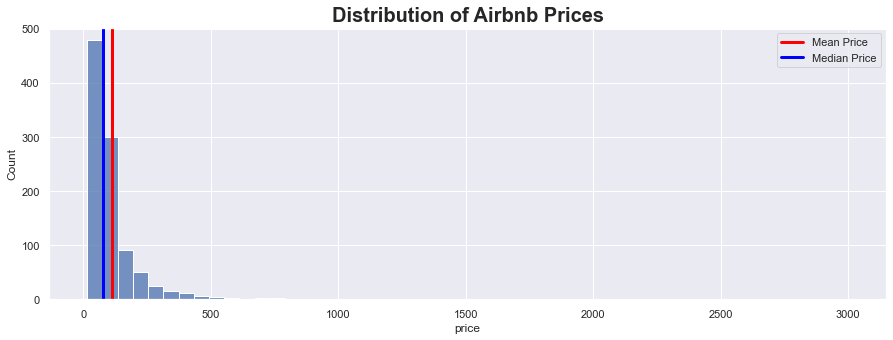

<IPython.core.display.Javascript object>

In [14]:
sns.set(rc={"figure.figsize": (15, 5)})
fig = plt.figure()
sns.histplot(data=train_df, x="price", bins=50)
plt.axvline(train_df["price"].mean(), c="red", ls="-", lw=3, label="Mean Price")
plt.axvline(train_df["price"].median(), c="blue", ls="-", lw=3, label="Median Price")
plt.title("Distribution of Airbnb Prices", fontsize=20, fontweight="bold")
plt.legend()
plt.show()

Sometimes it might be advisable to take a closer look at the log-distribution of the prices, which, often depending on the chosen sample size, looks pretty much like a normal distribution.

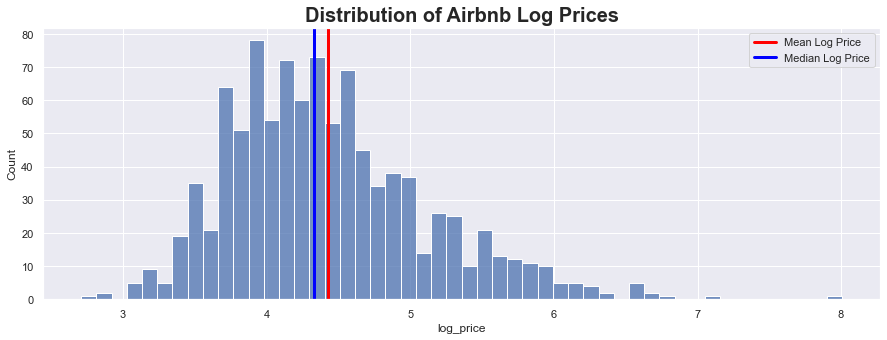

<IPython.core.display.Javascript object>

In [15]:
sns.set(rc={"figure.figsize": (15, 5)})
fig = plt.figure()
sns.histplot(data=train_df, x="log_price", bins=50)
plt.axvline(train_df["log_price"].mean(), c="red", ls="-", lw=3, label="Mean Log Price")
plt.axvline(
    train_df["log_price"].median(),
    c="blue",
    ls="-",
    lw=3,
    label="Median Log Price",
)
plt.title("Distribution of Airbnb Log Prices", fontsize=20, fontweight="bold")
plt.legend()
plt.show()

Additionaly we take a closer look at some of the variables which are chosen at random, although I do expect that the chosen 3 variables, namely the room type, whether the host is a so-called "superhost" and the number of people the apartment accomodates has a significant impact on the rental price. However, this is by no means validated and thus you should not be too strongly influenced by my choice.

C:\Users\anton\AppData\Local\Temp/ipykernel_6748/4015610632.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\anton\AppData\Local\Temp/ipykernel_6748/4015610632.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\anton\AppData\Local\Temp/ipykernel_6748/4015610632.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


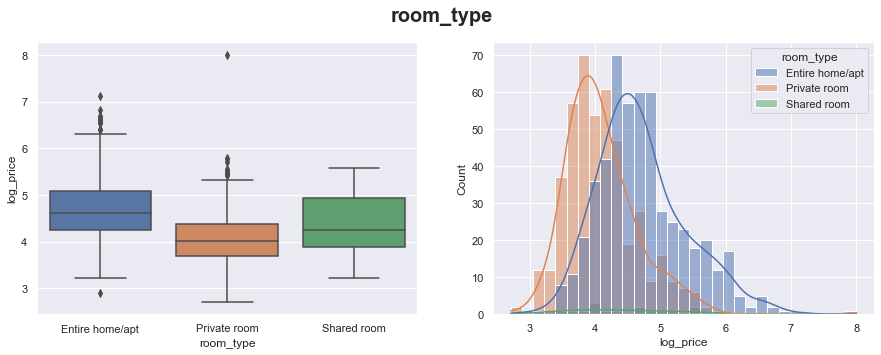

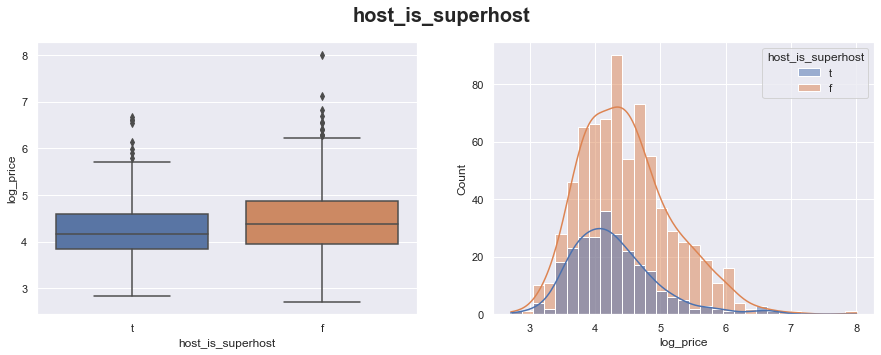

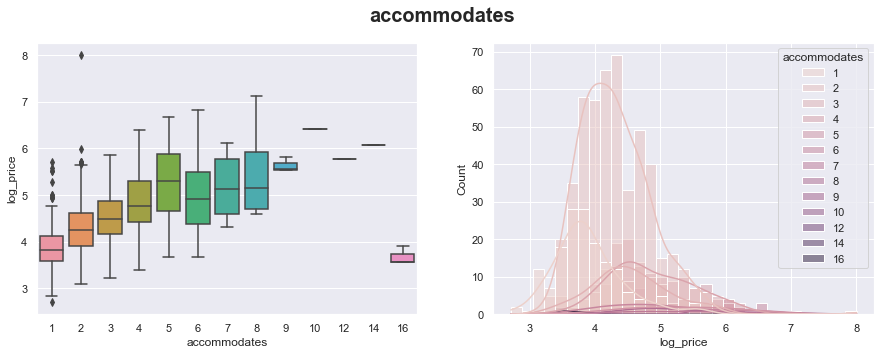

<IPython.core.display.Javascript object>

In [16]:
feature_variables = [
    "room_type",
    "host_is_superhost",
    "accommodates",
]

# for each of the above listed feature variables
# show a boxplot and distribution plot against the log price
for variable in feature_variables:
    fig, ax = plt.subplots(1, 2)
    sns.boxplot(data=train_df, x=variable, y="log_price", ax=ax[0])
    sns.histplot(train_df, x="log_price", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight="bold")
    fig.show()

Now, we take a look at the host images and the flat images. Therefore we write a simple function that plots the stored images and labels them with the given apartment rental price. 

In [17]:
def plot_images_and_prices(
    df, desired_price=None, num_images=5, random_state=202, pics="pic_host"
):
    """plots images and respective prices

    Args:
        df (pd.DataFrame): DataFrame eveyrthing is stored in. Prices and images as arrays
        desired_price (float, optional): If you want to only view images with a specified rental price. Defaults to None.
        num_images (int, optional): Number of images to be plotted. Defaults to 5.
        random_state (int, optional): . Defaults to 101.
        pics (str, optional): column Name in df where images are stored. Defaults to "pic_host".
    """

    num_images = num_images

    # set the rample state for the sampling for reproducibility
    random_state = random_state

    # only select entries with given price when specified
    if desired_price != None:
        random_sample = (
            df[df["price"] == desired_price]
            .sample(num_images, random_state=random_state)
            .reset_index(drop=True)
        )
    else:
        random_sample = df.sample(num_images, random_state=random_state)

    for i in range(num_images):

        price = random_sample.iloc[i]["price"]
        plt.subplot(1, num_images, i + 1)

        title = price
        plt.title(title)

        # turn off gridlines
        plt.axis("off")

        plt.imshow(random_sample.iloc[i][pics])
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

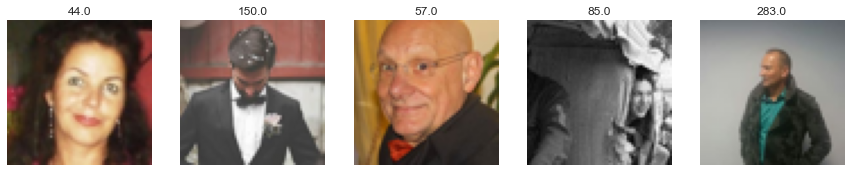

<IPython.core.display.Javascript object>

In [18]:
# plot the hosts
plot_images_and_prices(train_df)

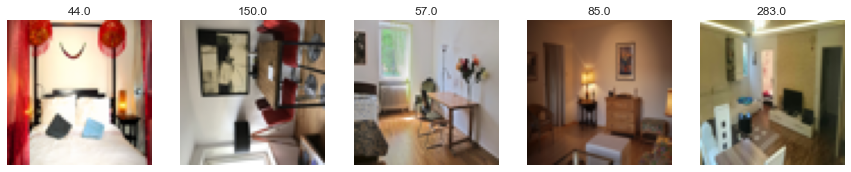

<IPython.core.display.Javascript object>

In [19]:
# plot the flats
plot_images_and_prices(train_df, pics="pic_flat")

# 3. Model building

To create a model, simpler models are first examined. This can be used, for example, to select the appropriate variables, since simple models often offer good interpretability. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.impute import SimpleImputer

from math import e

<IPython.core.display.Javascript object>

First, we select only a few of the variables for easier computation. An adewuate variable selection will be of crucial importance for your model, however, for this simple introduction I just picked what I thought might be reasonable. Additionaly, I chose variables that might be correlated with one another as bedrooms and beds, but did not adjust for that in my modeling as you might see later.

We choose the log-price as Y, as we will start with a simple linear regression where the normality assumption is crucial.

As the chosen feature variables we selected:

* "host_is_superhost"
* "latitude"
* "longitude"
* "room_type"
* "accommodates"
* "bedrooms"
* "number_of_reviews"
* "review_scores_value"


Most of these are self explanatory, but you can look up their exact meaning at: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

In [21]:
Y = train_df["log_price"]

train_df = train_df[
    [
        "host_is_superhost",
        "latitude",
        "longitude",
        "room_type",
        "accommodates",
        "bedrooms",
        "minimum_nights",
        "number_of_reviews",
        "review_scores_value",
        "host_identity_verified",
    ]
]

<IPython.core.display.Javascript object>

There are several ways to deal with missing data. The obvious one is to simply drop all rows where you encounter any missing (or unreasonable, e.g. 10 billion beds) values. Sometimes this might even be advisable. However, I chose to use a fairly straight forward method by simply replacing the missing values with the respective median values of the features. I chose the median, as the mean of e.g. number of bedrooms is not really meaningful, with e.g. 1.19.

Additionally we dummy decode the column "room_type", hus creating additional columns.

In [22]:
train_df.isna().sum()

host_is_superhost          0
latitude                   0
longitude                  0
room_type                  0
accommodates               0
bedrooms                  47
minimum_nights             0
number_of_reviews          0
review_scores_value       92
host_identity_verified     0
dtype: int64

<IPython.core.display.Javascript object>

In [23]:
imputer = SimpleImputer(strategy="median")


imputer = imputer.fit(
    train_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

train_df[
    [
        "accommodates",
        "bedrooms",
        "number_of_reviews",
        "review_scores_value",
        "minimum_nights",
    ]
] = imputer.transform(
    train_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

<IPython.core.display.Javascript object>

In [24]:
rooms = pd.get_dummies(train_df["room_type"], prefix="room")
train_df = train_df.drop("room_type", axis=1)
train_df["host_is_superhost"] = train_df["host_is_superhost"].map(dict(t=1, f=0))
train_df["host_identity_verified"] = train_df["host_identity_verified"].map(
    dict(t=1, f=0)
)
train_df = pd.concat([train_df, rooms], axis=1)
train_df

,host_is_superhost,latitude,longitude,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_value,host_identity_verified,room_Entire home/apt,room_Private room,room_Shared room
0,1,48.11492,11.48954,2.0,1.0,2.0,129.0,4.73,1,1,0,0
1,0,48.12071,11.63758,5.0,1.0,2.0,53.0,4.60,1,1,0,0
2,1,48.15199,11.56482,4.0,1.0,3.0,100.0,4.82,1,1,0,0
3,0,48.13855,11.46586,2.0,1.0,5.0,34.0,4.34,1,1,0,0
4,1,48.10814,11.52733,4.0,1.0,2.0,491.0,4.90,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,48.11631,11.58285,2.0,1.0,3.0,3.0,5.00,1,1,0,0
995,0,48.13716,11.54518,2.0,1.0,1.0,168.0,4.63,1,0,1,0
996,0,48.14544,11.57616,8.0,3.0,2.0,10.0,3.78,1,1,0,0
997,0,48.11841,11.60765,3.0,1.0,3.0,6.0,4.67,1,0,1,0


<IPython.core.display.Javascript object>

For a visual interpretation of our following model results we define a simple plotting function that plots the actual prices vs our predicted prices

In [25]:
# let's see what our predictions look like vs the actual
def ActualvPredictionsGraph(test_y, pred_y, title, prob=False):
    if max(test_y) >= max(pred_y):
        my_range = int(max(test_y))
    else:
        my_range = int(max(pred_y))
    plt.figure(figsize=(12, 3))
    plt.scatter(range(len(test_y)), test_y, color="blue")
    plt.scatter(range(len(pred_y)), pred_y, color="red")
    plt.xlabel("Index ")
    plt.ylabel("Log_price")
    plt.title(title, fontdict={"fontsize": 15})
    plt.legend(
        handles=[
            mpatches.Patch(color="red", label="prediction"),
            mpatches.Patch(color="blue", label="actual"),
        ]
    )
    plt.show()

    if prob:
        # plot actual v predicted in histogram form
        plt.figure(figsize=(12, 4))
        sns.histplot(predict_test, color="r", alpha=0.3, stat="probability", kde=True)
        sns.histplot(test_y, color="b", alpha=0.3, stat="probability", kde=True)
        plt.legend(labels=["prediction", "actual"])
        plt.title("Actual v Predict Distribution" + str(title))
        plt.show()

<IPython.core.display.Javascript object>

Before we start modelling, we need to agree on an evaluation method. Obviously for a simple linear regression we could use the R^2, adjusted R2 or AIC metric, but as later we are introducing neural networks I want to use a simple and straight forward method of evluating the model predictions. For that purpose we will use the Root Mean Square Error (RMSE) metric.

\begin{equation}
RMSE = \sqrt {\sum_{i=1}^{n} \frac{\hat{y_i} - y_i}{n}},
\end{equation}

where $\hat{y}$ is the predicted price. Be aware that the imported function is only the Mean Squared Error (MSE) which is why we take the squareroot by using **0.5


For that purpose we will split our data set into a training data set and a testing data set.

In [26]:
train_x, test_x, train_y, test_y = train_test_split(
    train_df, Y, test_size=0.25, random_state=0
)

<IPython.core.display.Javascript object>

First, lets try a "stupid model" that only predicts the mean of the training data, in our case the mean log price of the training data. 

In [27]:
def stupid_model_prediction(y_train, y_test):
    a = np.empty(len(test_y))
    a.fill(np.mean(train_y))
    return a


pred_y = stupid_model_prediction(train_y, test_y)

<IPython.core.display.Javascript object>

In [28]:
print("RMSE on test data: ", mean_squared_error(test_y, pred_y) ** (0.5))

RMSE on test data:  0.6768267645287421


<IPython.core.display.Javascript object>

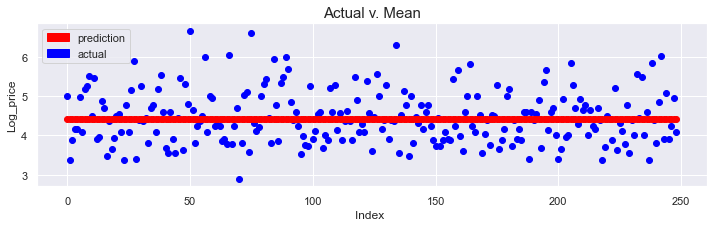

<IPython.core.display.Javascript object>

In [29]:
ActualvPredictionsGraph(test_y, pred_y, "Actual v. Mean")

## Linear Regression Model

You should all be familiar with the simple linear regression model. 
\begin{equation}
\mathbf{Y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}
However, you might not have fitted a regression using python. 

To use a linear regression in python is similarly easy as it is using it in R. Unfortunately, sklearn does not offer a summary as nice as the R-version does. If you are interested in a similar regression output you could use e.g. statsmodels or create the output yourself by e.g. using sklearns metrics as the introduced MSE.

In [30]:
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

predict_train = model_LR.predict(train_x)
predict_test = model_LR.predict(test_x)
# Root Mean Squared Error on train and test date

print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.5481287084559667
RMSE on test data:  0.5890191011375034


<IPython.core.display.Javascript object>

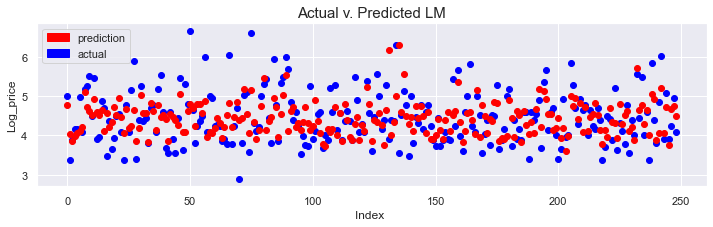

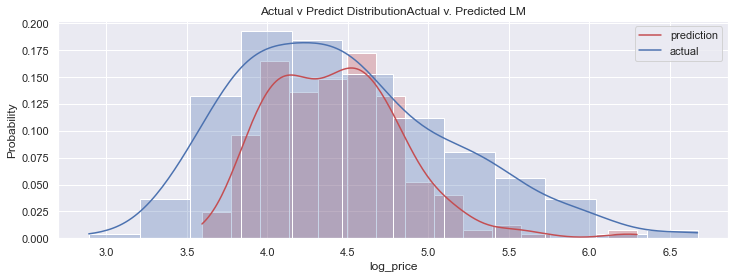

<IPython.core.display.Javascript object>

In [31]:
# plot it
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted LM", prob=True)

Decision trees are algorithms that can be used in both, regression and classification. They are basically using a set of binary rules and are thus very easy to interpret. A decision tree, just as a real tree has subsequently branches, nodes and leaves.

A tree could e.g. look something like this:

<img src="Screen-Shot-2019-05-17-at-00.09.26.png">

For more information on decision trees see e.g. https://gdcoder.com/decision-tree-regressor-explained-in-depth/ (where this graphic is taken from) 

In [32]:
tree_reg = DecisionTreeRegressor(max_depth=3, min_samples_split=10)

# train the model
tree_reg.fit(train_x, train_y)

# predict the response for the test data
predict_train = tree_reg.predict(train_x)
predict_test = tree_reg.predict(test_x)

# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.5446641380995653
RMSE on test data:  0.5660350658231571


<IPython.core.display.Javascript object>

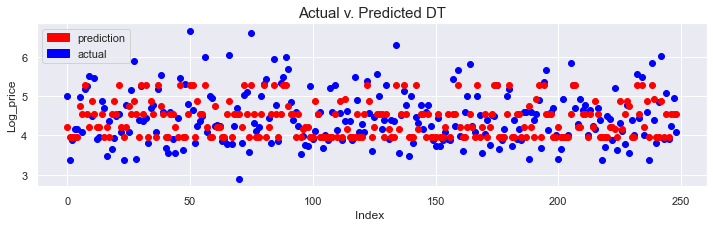

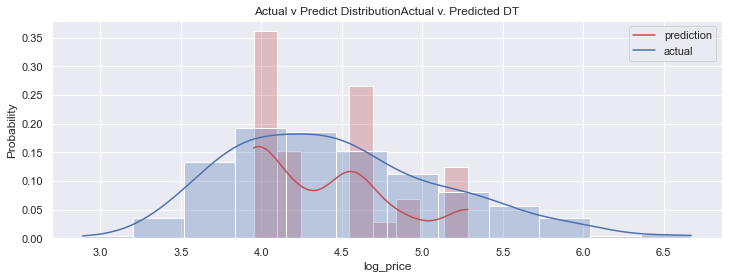

<IPython.core.display.Javascript object>

In [33]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted DT", prob=True)

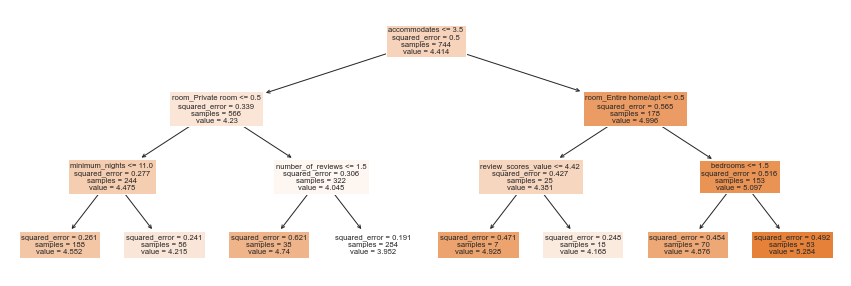

<IPython.core.display.Javascript object>

In [34]:
# visualize the decision tree
fig = plt.figure(figsize=(15, 5))
plot = tree.plot_tree(
    tree_reg, feature_names=train_x.columns.values.tolist(), filled=True
)

The overall performance of the decision trees is fairly similar to the performance of a simple linear regression. However, wee see an accumulation of predictions around certain prices due to the inherent model structure of binary decisions.

A similar and very common approach is a random forest regression:

In [35]:
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.2516792454178886
RMSE on test data:  0.5128112525470042


<IPython.core.display.Javascript object>

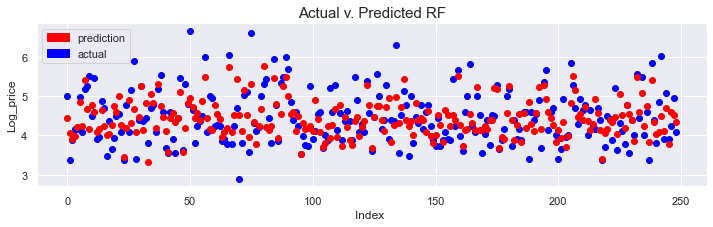

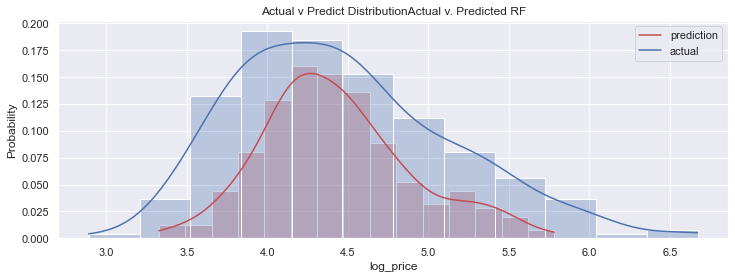

<IPython.core.display.Javascript object>

In [36]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted RF", prob=True)


<AxesSubplot:>

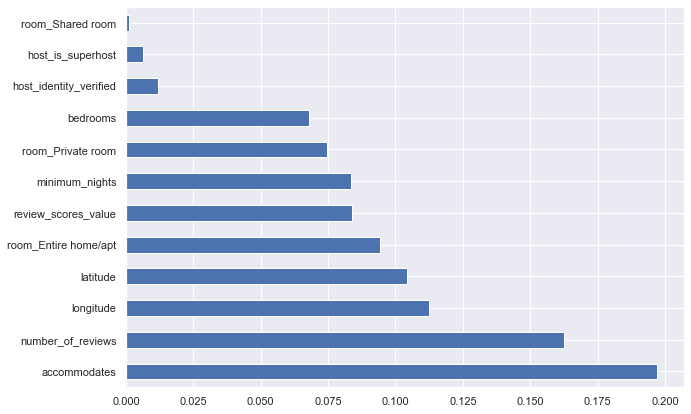

<IPython.core.display.Javascript object>

In [37]:
plt.figure(figsize=(10, 7))
feat_importances = pd.Series(model_RFR.feature_importances_, index=train_x.columns)
feat_importances.nlargest(train_df.shape[1]).plot(kind="barh")

This plot gives the "importance" of our input variables/features in the model. This could e.g. give us a reason to drop some of our used variables.

Now we want to build our first Multi Layer Perceptron. In this Notebook I will be using firstly the very inflexible MLPRegressor from scikit-learn and secondly a simple Tensorflow-Keras Implementation. You are, however, by no means in any way restricted and can use e.g. Tensorflow, Pytorch, Caffe or any other library you find suitable or implement everything on your own.

Commonly the weights in neural networks are initialized to random small numbers (most often with a random draw from a truncated normal distribution with mean=0 and variance=1) and updated with a given (and often cahnging/flexible) small learning rate.
Given this use of small weights the scale of inputs (and outputs) is an important factor. Unscaled input variables can result in a slow or unstable learning process which in turn can lead to a bad performance. Unscaled output variables (in our case the price) can lead to exploding gradients.

As we have already scaled our prices with a log-transformation we will apply a MinMax Scaling approach to our input variables.



\begin{equation}
x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}
\end{equation}


###### As you can see in the formula this has no effect on the dummy variables. However, our implementation has an effect on the "categorical" variables as e.g. "accommodates" or "beds". It might therefore maybe be more approriate to use e.g. One-Hot-Encoding for the categorical variables. I have not implemented this in the present notebook as this is purely introductory, so you should definetly have in mind that the variables selection, feature extraction and preprocessing is a very important part of your model building and should not simply be copied from this notebook 

In [38]:
# try with minmax scaled data -> also usefull for MLP
mn = MinMaxScaler()
x_train_scaled = pd.DataFrame(mn.fit_transform(train_x), columns=train_x.columns)
x_test_scaled = pd.DataFrame(mn.fit_transform(test_x), columns=test_x.columns)

<IPython.core.display.Javascript object>

In [39]:
MLPreg = MLPRegressor(
    hidden_layer_sizes=(1),
    activation="relu",
    random_state=101,
    max_iter=2000,
).fit(x_train_scaled, train_y)

<IPython.core.display.Javascript object>

In [40]:
predict_train = MLPreg.predict(x_train_scaled)
predict_test = MLPreg.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.6141452222941899
RMSE on test data:  0.6609679723792856


<IPython.core.display.Javascript object>

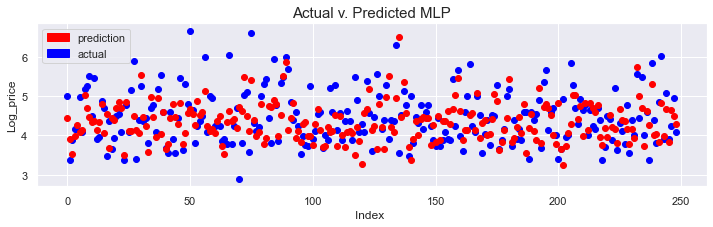

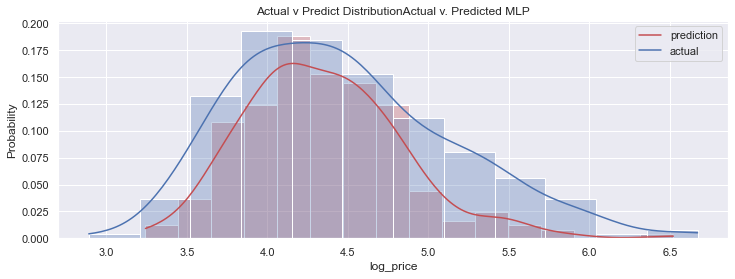

<IPython.core.display.Javascript object>

In [41]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted MLP", prob=True)


Now let's implement a simple MLP with tensorflow Keras:

In [42]:
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    MaxPool2D,
    AveragePooling2D,
    Input,
    Activation,
    BatchNormalization,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.callbacks import EarlyStopping

<IPython.core.display.Javascript object>

In [43]:
# first define the validation split, number of epochs and the batch size

split = 0.2
epochs = 200
batch_size = 64

<IPython.core.display.Javascript object>

In [44]:
# lets create a susper simple model with just 1 layer

model = Sequential()
model.add(Dense(1, activation="linear", input_shape=(x_train_scaled.shape[1],)))

<IPython.core.display.Javascript object>

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [46]:
model.compile(optimizer="adam", loss="mse", metrics="mae")

history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/200
10/10 [==============================] - 0s 13ms/step - loss: 21.2416 - mae: 4.5382 - val_loss: 21.7971 - val_mae: 4.5994
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 20.7730 - mae: 4.4863 - val_loss: 21.3225 - val_mae: 4.5473
Epoch 3/200
10/10 [==============================] - 0s 720us/step - loss: 20.3074 - mae: 4.4345 - val_loss: 20.8584 - val_mae: 4.4959
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 19.8552 - mae: 4.3831 - val_loss: 20.3974 - val_mae: 4.4442
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 19.4070 - mae: 4.3318 - val_loss: 19.9469 - val_mae: 4.3930
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 18.9658 - mae: 4.2809 - val_loss: 19.5034 - val_mae: 4.3420
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 18.5363 - mae: 4.2303 - val_loss: 19.0662 - val_mae: 4.2912
Epoch 8/200
10/10 [==============================] - 0s 812us/step

10/10 [==============================] - 0s 3ms/step - loss: 4.4675 - mae: 1.9429 - val_loss: 4.8366 - val_mae: 2.0079
Epoch 63/200
10/10 [==============================] - 0s 3ms/step - loss: 4.3462 - mae: 1.9108 - val_loss: 4.7119 - val_mae: 1.9764
Epoch 64/200
10/10 [==============================] - 0s 4ms/step - loss: 4.2271 - mae: 1.8792 - val_loss: 4.5911 - val_mae: 1.9456
Epoch 65/200
10/10 [==============================] - 0s 3ms/step - loss: 4.1116 - mae: 1.8481 - val_loss: 4.4741 - val_mae: 1.9154
Epoch 66/200
10/10 [==============================] - 0s 3ms/step - loss: 3.9995 - mae: 1.8171 - val_loss: 4.3595 - val_mae: 1.8853
Epoch 67/200
10/10 [==============================] - 0s 3ms/step - loss: 3.8906 - mae: 1.7863 - val_loss: 4.2475 - val_mae: 1.8555
Epoch 68/200
10/10 [==============================] - 0s 3ms/step - loss: 3.7840 - mae: 1.7559 - val_loss: 4.1382 - val_mae: 1.8259
Epoch 69/200
10/10 [==============================] - 0s 953us/step - loss: 3.6802 - mae:

Epoch 124/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0776 - mae: 0.8032 - val_loss: 1.3407 - val_mae: 0.8671
Epoch 125/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0629 - mae: 0.7971 - val_loss: 1.3244 - val_mae: 0.8604
Epoch 126/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0483 - mae: 0.7909 - val_loss: 1.3092 - val_mae: 0.8539
Epoch 127/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0347 - mae: 0.7851 - val_loss: 1.2948 - val_mae: 0.8478
Epoch 128/200
10/10 [==============================] - 0s 2ms/step - loss: 1.0221 - mae: 0.7799 - val_loss: 1.2804 - val_mae: 0.8414
Epoch 129/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0091 - mae: 0.7743 - val_loss: 1.2670 - val_mae: 0.8356
Epoch 130/200
10/10 [==============================] - 0s 2ms/step - loss: 0.9972 - mae: 0.7693 - val_loss: 1.2542 - val_mae: 0.8303
Epoch 131/200
10/10 [==============================] - 0s 2ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.6970 - mae: 0.6474 - val_loss: 0.9237 - val_mae: 0.6800
Epoch 186/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6945 - mae: 0.6464 - val_loss: 0.9208 - val_mae: 0.6787
Epoch 187/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6918 - mae: 0.6454 - val_loss: 0.9181 - val_mae: 0.6775
Epoch 188/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6893 - mae: 0.6443 - val_loss: 0.9154 - val_mae: 0.6764
Epoch 189/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6869 - mae: 0.6433 - val_loss: 0.9126 - val_mae: 0.6752
Epoch 190/200
10/10 [==============================] - 0s 1ms/step - loss: 0.6844 - mae: 0.6423 - val_loss: 0.9099 - val_mae: 0.6740
Epoch 191/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6820 - mae: 0.6412 - val_loss: 0.9074 - val_mae: 0.6730
Epoch 192/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6797 -

<IPython.core.display.Javascript object>

8/8 [==============================] - 0s 2ms/step - loss: 0.6695 - mae: 0.6403


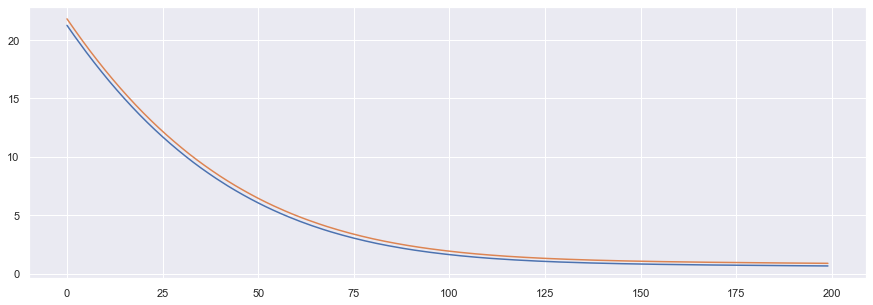

<IPython.core.display.Javascript object>

In [47]:
loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [48]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.8398191549022341
RMSE on test data:  0.8182317759628805


<IPython.core.display.Javascript object>

# Activation Functions

For this implementation, we will only use two activation functions, namely the Rectified Linear Uni activation function and the linear activation function. However there are obviously multiple other alternatives which could be used.
The two used activation functions are so-called Ridge functions, as they are multivariate functions acting on a linear combination of the input variables. 

### Rectified Linear Activation Function:

\begin{equation}
f (x) = \left\{
\begin{array}{ll}
x & x > 0 \\
0 & \, \textrm{else} \\
\end{array}
\right.
\end{equation}

The ReLU activation function is pretty simple. It is 0, once x is smaller or equal to zero and x, whenever x is bigger than zero. We could write this function in a loop simply as:
```
outputs = []
for value in inputs:
    if value > 0:
        outputs.append(x)
    elif value <= 0:
        outputs.append(0)    
```

However, this can easily be done in one line, by simply taking the maximum between the value itself and 0:

```
np.maximum(0, value)
```

The derivative of the ReLU function is equally as easy and simply not defined for x = 0:

\begin{equation}
f (x) = \left\{
\begin{array}{ll}
1 & x > 0 \\
0 & x < 0 \\
\end{array}
\right.
\end{equation}

### Linear
just returns the input as it is

Let's define these functions and visualize them. Luckily, when using activation functions in our models, they are impemented in basically all available librarys and can simply be used, e.g. with activation="ReLU" in Tensorflow-Keras.

In [49]:
def ReLU(inputs):
    return np.maximum(0, inputs)

def linear(inputs):
    return inputs


<IPython.core.display.Javascript object>

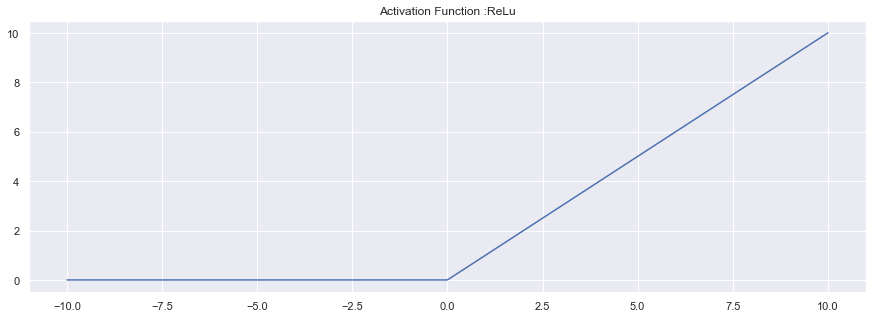

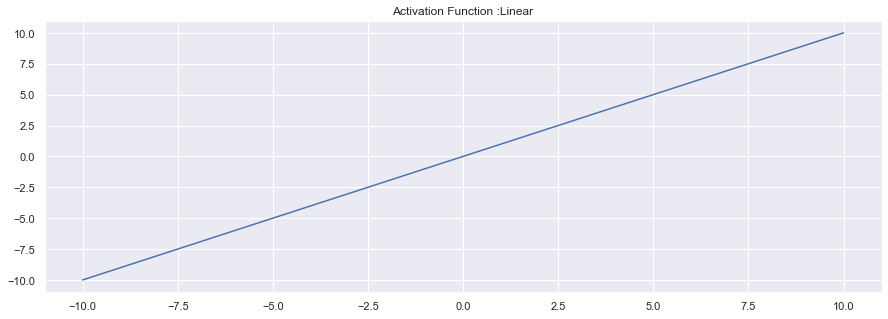

<IPython.core.display.Javascript object>

In [50]:
# Now lets first create some artificial input

x = np.linspace(-10, 10, 500)

# And then plot the two activation functions

plt.plot(x, ReLU(x))
plt.title("Activation Function :ReLu")
plt.show()


plt.plot(x, linear(x))
plt.title("Activation Function :Linear")
plt.show()

Now we will build a more complex MLP with multiple Layers, but always use the linear activation function

In [51]:
# let's build a more complex model and increase the number of epochs
epochs = 500

model = Sequential()
model.add(Dense(64, activation="linear", input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                832       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

The number of parameters for a MLP is very simply calculated by calculating the connections between layers + biases in every layer. 

\begin{equation}
n_{params} = (i×h + h×o) + (h+o)
\end{equation}

where i = input,
h = hidden layers
o = output.

For our model, this gives us:
\begin{equation}
12*64 + 64*128 + 128*64 + 64*32 + 32*1 + 64 + 128 + 64 + 32 +1
= 19521
\end{equation}


In [52]:
model.compile(optimizer="adam", loss="mse", metrics="mae")

history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/500
10/10 [==============================] - 0s 9ms/step - loss: 6.9237 - mae: 2.2089 - val_loss: 2.6765 - val_mae: 1.4423
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 1.8426 - mae: 1.1454 - val_loss: 1.1787 - val_mae: 0.7679
Epoch 3/500
10/10 [==============================] - 0s 818us/step - loss: 0.9578 - mae: 0.7247 - val_loss: 0.7953 - val_mae: 0.6698
Epoch 4/500
10/10 [==============================] - 0s 794us/step - loss: 0.6123 - mae: 0.6220 - val_loss: 0.6813 - val_mae: 0.6381
Epoch 5/500
10/10 [==============================] - 0s 917us/step - loss: 0.5244 - mae: 0.5357 - val_loss: 0.6594 - val_mae: 0.6022
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 0.4688 - mae: 0.5231 - val_loss: 0.5726 - val_mae: 0.5751
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4341 - mae: 0.4996 - val_loss: 0.5566 - val_mae: 0.5527
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.40

Epoch 63/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3246 - mae: 0.4384 - val_loss: 0.3562 - val_mae: 0.4304
Epoch 64/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3041 - mae: 0.4250 - val_loss: 0.3571 - val_mae: 0.4185
Epoch 65/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2966 - mae: 0.4159 - val_loss: 0.3478 - val_mae: 0.4162
Epoch 66/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2968 - mae: 0.4206 - val_loss: 0.3461 - val_mae: 0.4114
Epoch 67/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3142 - mae: 0.4374 - val_loss: 0.3697 - val_mae: 0.4190
Epoch 68/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2939 - mae: 0.4202 - val_loss: 0.3791 - val_mae: 0.4231
Epoch 69/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3241 - mae: 0.4383 - val_loss: 0.3527 - val_mae: 0.4179
Epoch 70/500
10/10 [==============================] - 0s 3ms/step - loss: 0.

Epoch 125/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3051 - mae: 0.4290 - val_loss: 0.3977 - val_mae: 0.4299
Epoch 126/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3151 - mae: 0.4397 - val_loss: 0.4603 - val_mae: 0.4801
Epoch 127/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3276 - mae: 0.4435 - val_loss: 0.4449 - val_mae: 0.4625
Epoch 128/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3417 - mae: 0.4575 - val_loss: 0.3549 - val_mae: 0.4148
Epoch 129/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3202 - mae: 0.4426 - val_loss: 0.3729 - val_mae: 0.4505
Epoch 130/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3121 - mae: 0.4358 - val_loss: 0.3532 - val_mae: 0.4347
Epoch 131/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2996 - mae: 0.4219 - val_loss: 0.3557 - val_mae: 0.4130
Epoch 132/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.3004 - mae: 0.4248 - val_loss: 0.3790 - val_mae: 0.4208
Epoch 187/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3154 - mae: 0.4306 - val_loss: 0.3798 - val_mae: 0.4221
Epoch 188/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3140 - mae: 0.4327 - val_loss: 0.3598 - val_mae: 0.4144
Epoch 189/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2965 - mae: 0.4227 - val_loss: 0.4814 - val_mae: 0.4898
Epoch 190/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3270 - mae: 0.4405 - val_loss: 0.3857 - val_mae: 0.4251
Epoch 191/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3045 - mae: 0.4226 - val_loss: 0.3683 - val_mae: 0.4160
Epoch 192/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3168 - mae: 0.4314 - val_loss: 0.3524 - val_mae: 0.4143
Epoch 193/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3102 -

Epoch 248/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2986 - mae: 0.4227 - val_loss: 0.3648 - val_mae: 0.4134
Epoch 249/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3026 - mae: 0.4212 - val_loss: 0.3629 - val_mae: 0.4148
Epoch 250/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2979 - mae: 0.4196 - val_loss: 0.3513 - val_mae: 0.4329
Epoch 251/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3101 - mae: 0.4260 - val_loss: 0.3633 - val_mae: 0.4375
Epoch 252/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3418 - mae: 0.4539 - val_loss: 0.3682 - val_mae: 0.4535
Epoch 253/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3593 - mae: 0.4682 - val_loss: 0.3438 - val_mae: 0.4167
Epoch 254/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3033 - mae: 0.4243 - val_loss: 0.3645 - val_mae: 0.4189
Epoch 255/500
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 2ms/step - loss: 0.2982 - mae: 0.4196 - val_loss: 0.3441 - val_mae: 0.4204
Epoch 310/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3145 - mae: 0.4298 - val_loss: 0.3628 - val_mae: 0.4478
Epoch 311/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3107 - mae: 0.4261 - val_loss: 0.3560 - val_mae: 0.4250
Epoch 312/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2975 - mae: 0.4207 - val_loss: 0.3827 - val_mae: 0.4198
Epoch 313/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3062 - mae: 0.4251 - val_loss: 0.3619 - val_mae: 0.4122
Epoch 314/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3175 - mae: 0.4331 - val_loss: 0.3678 - val_mae: 0.4172
Epoch 315/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2989 - mae: 0.4246 - val_loss: 0.3862 - val_mae: 0.4246
Epoch 316/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2987 -

Epoch 371/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3101 - mae: 0.4371 - val_loss: 0.4242 - val_mae: 0.4472
Epoch 372/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3123 - mae: 0.4385 - val_loss: 0.3789 - val_mae: 0.4199
Epoch 373/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2953 - mae: 0.4163 - val_loss: 0.3456 - val_mae: 0.4194
Epoch 374/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2939 - mae: 0.4170 - val_loss: 0.3548 - val_mae: 0.4104
Epoch 375/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2989 - mae: 0.4193 - val_loss: 0.3567 - val_mae: 0.4115
Epoch 376/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2978 - mae: 0.4220 - val_loss: 0.3849 - val_mae: 0.4265
Epoch 377/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3027 - mae: 0.4233 - val_loss: 0.3514 - val_mae: 0.4117
Epoch 378/500
10/10 [==============================] - 0s 2ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.2958 - mae: 0.4195 - val_loss: 0.3596 - val_mae: 0.4127
Epoch 433/500
10/10 [==============================] - 0s 4ms/step - loss: 0.2996 - mae: 0.4213 - val_loss: 0.3493 - val_mae: 0.4101
Epoch 434/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2969 - mae: 0.4203 - val_loss: 0.3467 - val_mae: 0.4134
Epoch 435/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2969 - mae: 0.4153 - val_loss: 0.3563 - val_mae: 0.4364
Epoch 436/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3091 - mae: 0.4275 - val_loss: 0.3473 - val_mae: 0.4085
Epoch 437/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3163 - mae: 0.4370 - val_loss: 0.3832 - val_mae: 0.4197
Epoch 438/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2972 - mae: 0.4188 - val_loss: 0.3562 - val_mae: 0.4104
Epoch 439/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2974 -

Epoch 494/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2966 - mae: 0.4191 - val_loss: 0.3463 - val_mae: 0.4089
Epoch 495/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2956 - mae: 0.4171 - val_loss: 0.3485 - val_mae: 0.4168
Epoch 496/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2942 - mae: 0.4194 - val_loss: 0.3723 - val_mae: 0.4164
Epoch 497/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3036 - mae: 0.4245 - val_loss: 0.3962 - val_mae: 0.4276
Epoch 498/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3139 - mae: 0.4330 - val_loss: 0.3746 - val_mae: 0.4171
Epoch 499/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3042 - mae: 0.4285 - val_loss: 0.3989 - val_mae: 0.4301
Epoch 500/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3034 - mae: 0.4204 - val_loss: 0.3725 - val_mae: 0.4179


<IPython.core.display.Javascript object>

8/8 [==============================] - 0s 3ms/step - loss: 0.3644 - mae: 0.4496


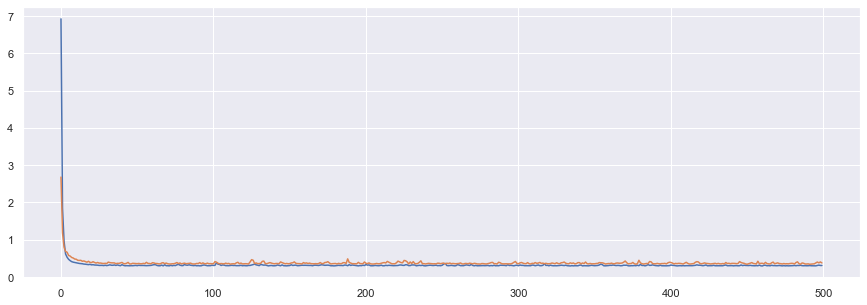

<IPython.core.display.Javascript object>

In [53]:
loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [54]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.56218186285408
RMSE on test data:  0.6036865394651224


<IPython.core.display.Javascript object>

Checking the plots it seems like we could have stopped training much earlier than we actually did. Let's define an early stopping criterion and rerun the same model with early stopping

Epoch 1/500
10/10 [==============================] - 0s 8ms/step - loss: 5.1981 - mae: 1.8861 - val_loss: 2.9123 - val_mae: 1.5026
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 1.3975 - mae: 0.9409 - val_loss: 1.5564 - val_mae: 0.9637
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 0.8444 - mae: 0.6882 - val_loss: 0.8031 - val_mae: 0.7152
Epoch 4/500
10/10 [==============================] - 0s 908us/step - loss: 0.5908 - mae: 0.6166 - val_loss: 0.7075 - val_mae: 0.6222
Epoch 5/500
10/10 [==============================] - 0s 879us/step - loss: 0.4974 - mae: 0.5256 - val_loss: 0.5827 - val_mae: 0.5889
Epoch 6/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4492 - mae: 0.5235 - val_loss: 0.5716 - val_mae: 0.5592
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4277 - mae: 0.4915 - val_loss: 0.5286 - val_mae: 0.5447
Epoch 8/500
10/10 [==============================] - 0s 921us/step - loss: 0.40

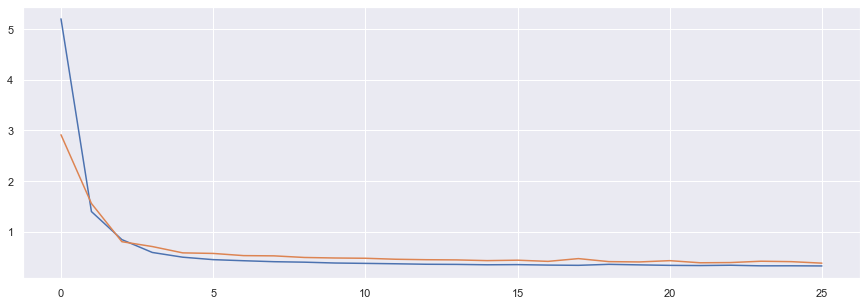

<IPython.core.display.Javascript object>

In [55]:
callback = EarlyStopping(monitor="mae", patience=4)


model = Sequential()
model.add(Dense(64, activation="linear", input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics="mae")


history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [56]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.5776008033446399
RMSE on test data:  0.6181534637625672


<IPython.core.display.Javascript object>

If you encounter severe overfitting (another) common pracitce is to add Dropout layers. In Keras that is easily achivable by simply using: model.add(Dropout(dropout_value)). e.g. as done below

# 4. Model building with images

Now lets first try a simple regression simply with the images of the flats. Based on the above quick view of the images we can assume that a regression based on images might not yield the best results

In [57]:
img_train_x, img_test_x, img_train_y, img_test_y = train_test_split(
    train_images_flat, Y, test_size=0.25, random_state=0
)

<IPython.core.display.Javascript object>

Epoch 1/100
10/10 [==============================] - 1s 41ms/step - loss: 8.9955 - mae: 2.5997 - val_loss: 2.0608 - val_mae: 1.1979
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 2.5964 - mae: 1.3531 - val_loss: 1.4104 - val_mae: 1.0152
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 1.5076 - mae: 0.9781 - val_loss: 1.5900 - val_mae: 0.9932
Epoch 4/100
10/10 [==============================] - 0s 35ms/step - loss: 1.1499 - mae: 0.8568 - val_loss: 1.0259 - val_mae: 0.7441
Epoch 5/100
10/10 [==============================] - 0s 34ms/step - loss: 0.9706 - mae: 0.7939 - val_loss: 0.7268 - val_mae: 0.6761
Epoch 6/100
10/10 [==============================] - 0s 33ms/step - loss: 1.0290 - mae: 0.8034 - val_loss: 0.8535 - val_mae: 0.6747
Epoch 7/100
10/10 [==============================] - 0s 33ms/step - loss: 0.9678 - mae: 0.7753 - val_loss: 0.8707 - val_mae: 0.6795
Epoch 8/100
10/10 [==============================] - 0s 33ms/step - loss: 0.

10/10 [==============================] - 0s 36ms/step - loss: 0.2890 - mae: 0.4205 - val_loss: 1.4829 - val_mae: 0.9905
Epoch 63/100
10/10 [==============================] - 0s 36ms/step - loss: 0.3163 - mae: 0.4392 - val_loss: 1.1438 - val_mae: 0.8262
Epoch 64/100
10/10 [==============================] - 0s 37ms/step - loss: 0.2803 - mae: 0.4204 - val_loss: 1.4193 - val_mae: 0.9580
Epoch 65/100
10/10 [==============================] - 0s 36ms/step - loss: 0.2481 - mae: 0.3912 - val_loss: 1.2369 - val_mae: 0.8604
Epoch 66/100
10/10 [==============================] - 0s 38ms/step - loss: 0.2763 - mae: 0.4084 - val_loss: 0.8465 - val_mae: 0.6840
Epoch 67/100
10/10 [==============================] - 0s 40ms/step - loss: 0.2681 - mae: 0.4034 - val_loss: 1.4210 - val_mae: 0.9569
Epoch 68/100
10/10 [==============================] - 0s 37ms/step - loss: 0.2340 - mae: 0.3817 - val_loss: 0.8494 - val_mae: 0.6883
Epoch 69/100
10/10 [==============================] - 0s 37ms/step - loss: 0.2074 

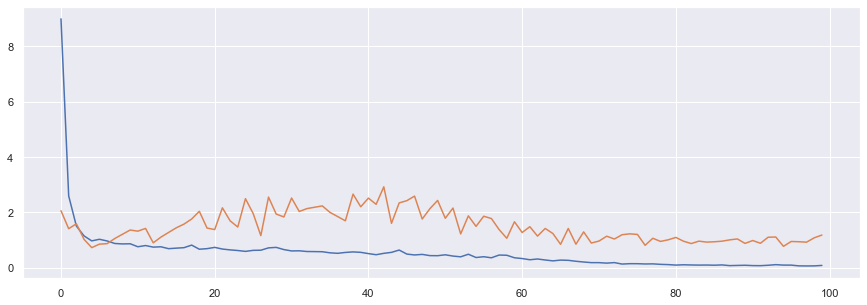

<IPython.core.display.Javascript object>

In [58]:
# lets first run the model without early stopping but ionly for 100 epochs
epochs = 100

img_model = Sequential()

img_model.add(
    Conv2D(
        64,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
        input_shape=train_images_flat[0].shape,
    )
)
img_model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))

img_model.add(
    Conv2D(
        128,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
    )
)
img_model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))

img_model.add(
    Conv2D(
        64,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
    )
)

img_model.add(Dropout(0.5))
img_model.add(Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="SAME"))
img_model.add(Flatten())
img_model.add(Dense(32, activation="relu"))
img_model.add(Dense(1, activation="linear"))
img_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

img_history = img_model.fit(
    img_train_x,
    img_train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)


loss, mae = img_model.evaluate(img_test_x, img_test_y)
# Step4.2 Plot the learning curve
plt.plot(img_history.history["loss"], label="train")
plt.plot(img_history.history["val_loss"], label="val")
plt.show()

In [59]:
predict_train = img_model.predict(img_train_x)
predict_test = img_model.predict(img_test_x)
print("RMSE on train data: ", mean_squared_error(img_train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(img_test_y, predict_test) ** (0.5))

RMSE on train data:  0.74329811887312
RMSE on test data:  1.00476014204888


<IPython.core.display.Javascript object>

Let's write a super ugly own train test split function to get ranom sample from the multiple datasets we have. There probably is a better solution for this, but this still works fine if you are carefull with the order of the arguments

In [60]:
def tt_split(*data, test_size=0.3, random_state=101):
    """Be aware of the input order of your arguments"""

    np.random.seed(random_state)

    len_list = [len(i) for i in data]
    if len(set(len_list)) != 1:
        raise ValueError("Lengths of input data must be identical")

    n = int(np.round(0.3 * len_list[0], 0))

    indexes = np.random.choice(len_list[0], n, replace=False)

    test_list = []
    train_list = []

    for i in range(len(data)):

        try:
            temp = data[i].values
        except AttributeError:
            temp = data[i]

        test_data = temp[indexes]
        train_data = temp[[i for i in range(len(temp)) if i not in indexes]]

        if type(data[i]) == pd.core.frame.DataFrame:
            test_data = pd.DataFrame(test_data, columns=data[i].columns)
            train_data = pd.DataFrame(train_data, columns=data[i].columns)

        test_list.append(test_data)
        train_list.append(train_data)

    return train_list, test_list


x, y = tt_split(train_df, train_images_host, train_images_flat, Y)

X_train, X_test, host_train, host_test, flat_train, flat_test, y_train, y_test = (
    x[0],
    y[0],
    x[1],
    y[1],
    x[2],
    y[2],
    x[3],
    y[3],
)

<IPython.core.display.Javascript object>

In [63]:
# model for Photo image
image_inputs = tf.keras.Input((64, 64, 3))

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = tf.keras.layers.Flatten()(x_image)

x_image = tf.keras.layers.Dense(128, activation="relu")(x_image)

x_image = tf.keras.layers.Dropout(0.5)(x_image)


# model for Meta data
meta_inputs = tf.keras.Input(shape=((12,)))

x_meta = tf.keras.layers.Dense(12, activation="relu")(meta_inputs)

x_meta = tf.keras.layers.Dense(24, activation="relu")(x_meta)

x_meta = tf.keras.layers.Dense(12, activation="relu")(x_meta)


# concatenate the "two" models
x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta])

output = tf.keras.layers.Dense(1)(x)
multi_model = tf.keras.Model(inputs=[image_inputs, meta_inputs], outputs=output)

<IPython.core.display.Javascript object>

In [64]:
# compile the model

multi_model.compile(loss="mse", metrics=["mae"], optimizer="adam")

callback = EarlyStopping(monitor="loss", patience=10)

# train the model
multi_model_history = multi_model.fit(
    [host_train, X_train],
    y_train,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

Epoch 1/100
9/9 [==============================] - 1s 51ms/step - loss: 8.0624 - mae: 2.2797 - val_loss: 3.8986 - val_mae: 1.6223
Epoch 2/100
9/9 [==============================] - 0s 38ms/step - loss: 2.4458 - mae: 1.2566 - val_loss: 1.1550 - val_mae: 0.8812
Epoch 3/100
9/9 [==============================] - 0s 37ms/step - loss: 1.6193 - mae: 1.0234 - val_loss: 1.2397 - val_mae: 0.8886
Epoch 4/100
9/9 [==============================] - 0s 38ms/step - loss: 1.3056 - mae: 0.9100 - val_loss: 1.1910 - val_mae: 0.8646
Epoch 5/100
9/9 [==============================] - 0s 38ms/step - loss: 1.1876 - mae: 0.8772 - val_loss: 0.8968 - val_mae: 0.7183
Epoch 6/100
9/9 [==============================] - 0s 37ms/step - loss: 1.0177 - mae: 0.7950 - val_loss: 0.8335 - val_mae: 0.6951
Epoch 7/100
9/9 [==============================] - 0s 37ms/step - loss: 0.9760 - mae: 0.7810 - val_loss: 0.9279 - val_mae: 0.7334
Epoch 8/100
9/9 [==============================] - 0s 39ms/step - loss: 0.8821 - mae: 0.73

9/9 [==============================] - 0s 37ms/step - loss: 0.0913 - mae: 0.2338 - val_loss: 0.4216 - val_mae: 0.5040
Epoch 64/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0907 - mae: 0.2283 - val_loss: 0.3790 - val_mae: 0.4762
Epoch 65/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0733 - mae: 0.2011 - val_loss: 0.4018 - val_mae: 0.4864
Epoch 66/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0744 - mae: 0.2044 - val_loss: 0.3901 - val_mae: 0.5039
Epoch 67/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0745 - mae: 0.2045 - val_loss: 0.3926 - val_mae: 0.5086
Epoch 68/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0906 - mae: 0.2320 - val_loss: 0.4351 - val_mae: 0.4893
Epoch 69/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0646 - mae: 0.1898 - val_loss: 0.3936 - val_mae: 0.4901
Epoch 70/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0689 - mae: 0.1975 - 

<IPython.core.display.Javascript object>

10/10 [==============================] - 0s 6ms/step - loss: 0.4458 - mae: 0.4939


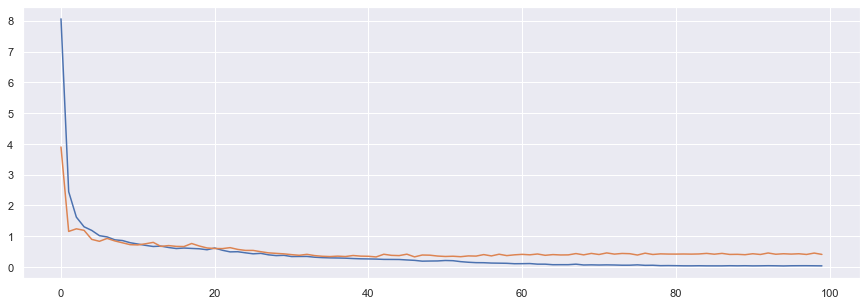

<IPython.core.display.Javascript object>

In [65]:
loss, mae = multi_model.evaluate(
    [host_test, X_test],
    y_test,
)
# Step4.2 Plot the learning curve
plt.plot(multi_model_history.history["loss"], label="train")
plt.plot(multi_model_history.history["val_loss"], label="val")
plt.show()

In [66]:
predict_train = multi_model.predict([host_train, X_train])
predict_test = multi_model.predict([host_test, X_test])
print("RMSE on train data: ", mean_squared_error(y_train, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(y_test, predict_test) ** (0.5))

RMSE on train data:  0.31802948946562926
RMSE on test data:  0.6676478337937639


<IPython.core.display.Javascript object>

In [67]:
# model for Photo image
image_inputs_x = tf.keras.Input((64, 64, 3))

# for first images
x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs_x)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = tf.keras.layers.Flatten()(x_image)

x_image = tf.keras.layers.Dense(128, activation="relu")(x_image)

x_image = tf.keras.layers.Dropout(0.5)(x_image)


# for second images
image_inputs_z = tf.keras.Input((64, 64, 3))

z_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs_z)

z_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(z_image)

z_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(z_image)

z_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(z_image)

z_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(z_image)

z_image = tf.keras.layers.Flatten()(z_image)

z_image = tf.keras.layers.Dense(128, activation="relu")(z_image)

z_image = tf.keras.layers.Dropout(0.5)(z_image)


# model for Meta data
meta_inputs = tf.keras.Input(shape=((12,)))
x_meta = tf.keras.layers.Dense(12, activation="relu")(meta_inputs)
x_meta = tf.keras.layers.Dense(24, activation="relu")(x_meta)
x_meta = tf.keras.layers.Dense(12, activation="relu")(x_meta)

# concat
x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta, z_image])
output = tf.keras.layers.Dense(1, activation="linear")(x)

multi_multi_model = tf.keras.Model(
    inputs=[image_inputs_x, meta_inputs, image_inputs_z], outputs=output
)

<IPython.core.display.Javascript object>

In [68]:
multi_multi_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 64)   1792        ['input_4[0][0]']                
                                                                                            

<IPython.core.display.Javascript object>

In [69]:
multi_multi_model.compile(loss="mse", metrics=["mae"], optimizer="adam")

callback = EarlyStopping(monitor="loss", patience=10)

# train the model
multi_multi_model_history = multi_multi_model.fit(
    [host_train, X_train, flat_train],
    y_train,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

Epoch 1/100
9/9 [==============================] - 1s 80ms/step - loss: 11.0717 - mae: 2.5683 - val_loss: 3.9511 - val_mae: 1.6763
Epoch 2/100
9/9 [==============================] - 1s 67ms/step - loss: 3.4485 - mae: 1.4273 - val_loss: 1.1990 - val_mae: 0.8283
Epoch 3/100
9/9 [==============================] - 1s 67ms/step - loss: 1.6395 - mae: 0.9937 - val_loss: 0.7244 - val_mae: 0.6938
Epoch 4/100
9/9 [==============================] - 1s 66ms/step - loss: 1.1011 - mae: 0.8391 - val_loss: 0.7992 - val_mae: 0.6791
Epoch 5/100
9/9 [==============================] - 1s 65ms/step - loss: 1.0677 - mae: 0.8154 - val_loss: 0.7382 - val_mae: 0.6431
Epoch 6/100
9/9 [==============================] - 1s 67ms/step - loss: 0.9854 - mae: 0.7773 - val_loss: 0.7383 - val_mae: 0.6313
Epoch 7/100
9/9 [==============================] - 1s 65ms/step - loss: 0.8429 - mae: 0.7073 - val_loss: 0.7562 - val_mae: 0.6350
Epoch 8/100
9/9 [==============================] - 1s 66ms/step - loss: 0.8616 - mae: 0.7

9/9 [==============================] - 1s 65ms/step - loss: 0.1054 - mae: 0.2499 - val_loss: 0.4378 - val_mae: 0.4953
Epoch 64/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0888 - mae: 0.2283 - val_loss: 0.4298 - val_mae: 0.4968
Epoch 65/100
9/9 [==============================] - 1s 67ms/step - loss: 0.0956 - mae: 0.2374 - val_loss: 0.4564 - val_mae: 0.5039
Epoch 66/100
9/9 [==============================] - 1s 65ms/step - loss: 0.0776 - mae: 0.2140 - val_loss: 0.4250 - val_mae: 0.4893
Epoch 67/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0732 - mae: 0.2061 - val_loss: 0.4120 - val_mae: 0.4917
Epoch 68/100
9/9 [==============================] - 1s 65ms/step - loss: 0.0722 - mae: 0.2039 - val_loss: 0.4467 - val_mae: 0.5066
Epoch 69/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0837 - mae: 0.2192 - val_loss: 0.4609 - val_mae: 0.5082
Epoch 70/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0687 - mae: 0.1984 - 

<IPython.core.display.Javascript object>

10/10 [==============================] - 0s 9ms/step - loss: 0.4565 - mae: 0.5119


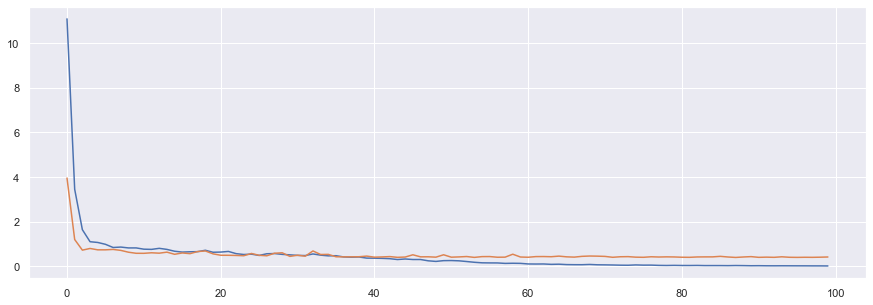

<IPython.core.display.Javascript object>

In [70]:
loss, mae = multi_multi_model.evaluate(
    [host_test, X_test, flat_test],
    y_test,
)
# Step4.2 Plot the learning curve
plt.plot(multi_multi_model_history.history["loss"], label="train")
plt.plot(multi_multi_model_history.history["val_loss"], label="val")
plt.show()

In [71]:
predict_train = multi_multi_model.predict([host_train, X_train, flat_train])
predict_test = multi_multi_model.predict([host_test, X_test, flat_test])
print("RMSE on train data: ", mean_squared_error(y_train, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(y_test, predict_test) ** (0.5))

RMSE on train data:  0.301198049190539
RMSE on test data:  0.6756563457835871


<IPython.core.display.Javascript object>

As this is just an introductory notebook, I again want to emphasize that the performance of these models is arbitrary and should not effect your model or variable choice.

In this notebook we have started with very simple methods, suited to analyse structured data. Even in the performed models any form of optimizing is missing and the variable selection was done at random. Therefore you have plenty of room to build better fitting models using more suitable variables.

Subsequently we have used 3 types of neural networks:
* Multi Layer Perceptrons to analyze structured data
* Convolutional Neural networks to analyze images
* Mixed Input Neural Networks to analyze structured data and images combined

